In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

target_path = "order_book_target.parquet"
feature_path = "order_book_feature.parquet"

df_target = pd.read_parquet(target_path)
df_feature = pd.read_parquet(feature_path)

spy_data = df_feature[df_feature['stock_id'] == 50200]

print(spy_data.head())




          stock_id  time_id  seconds_in_bucket  bid_price1  ask_price1  \
13501269     50200       12                1.0      370.62      370.64   
13501270     50200       12                2.0      370.68      370.70   
13501271     50200       12                3.0      370.66      370.69   
13501272     50200       12                4.0      370.75      370.77   
13501273     50200       12                5.0      370.79      370.83   

          bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
13501269      370.61      370.65        100        100        200         63  
13501270      370.67      370.71          7        100        257        200  
13501271      370.64      370.70        200        100        100        300  
13501272      370.74      370.78        100        100        200        100  
13501273      370.78      370.84        557        400        500        300  


/var/folders/xs/syvgwg793y728s7cfp63yz5w0000gn/T/ipykernel_46253/776687538.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_data['bucket'] = spy_data['seconds_in_bucket']//100


In [ ]:
# add bucket, every 30s one bucket
spy_data['bucket'] = spy_data['seconds_in_bucket']//100

# agg and mean the data
bucketed_spy = spy_data.groupby(['stock_id', 'time_id', 'bucket']).mean(numeric_only=True).reset_index()


def compute_orderbook_features(bucketed_spy):
    spy_data = bucketed_spy.copy()

    spy_data['mid_price'] = (spy_data['bid_price1'] + spy_data['ask_price1']) / 2
    spy_data['wap'] = (spy_data['bid_price1'] * spy_data['ask_size1'] + spy_data['ask_price1'] * spy_data['bid_size1']) / (
        spy_data['bid_size1'] + spy_data['ask_size1']
    )
    spy_data['bid_ask_spread'] = spy_data['ask_price1'] - spy_data['bid_price1']
    spy_data['spread_pct'] = spy_data['bid_ask_spread'] / spy_data['mid_price']

    spy_data['spread_variation'] = spy_data.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    spy_data['imbalance'] = (spy_data['bid_size1'] - spy_data['ask_size1']) / (spy_data['bid_size1'] + spy_data['ask_size1'])
    spy_data['depth_ratio'] = spy_data['bid_size1'] / spy_data['ask_size1'].replace(0, np.nan)
    
    keep_cols = [
        'stock_id', 'time_id', 'bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation'
    ]
    return spy_data[keep_cols]
bucketed_spy.to_csv("bucketed_spy_50200_data.csv", index=False)

In [25]:
spy_feat = compute_orderbook_features(spy_data)

def realized_volatility(series):
    return np.sqrt(np.sum(np.square(np.diff(np.log(series)))))

rv_df = spy_feat.groupby("time_id")["wap"].apply(realized_volatility).reset_index()
rv_df.columns = ["time_id", "rv"]

feature_agg = spy_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std'],
    'depth_ratio': ['mean', 'std'],
})
feature_agg.columns = ['_'.join(col) for col in feature_agg.columns]
feature_agg = feature_agg.reset_index()

data = pd.merge(feature_agg, rv_df, on="time_id", how="inner")



print(rv_df.head())


   time_id        rv
0       12  0.002669
1       13  0.002228
2       14  0.001771
3       15  0.000957
4       16  0.001646


In [26]:
# feature engine
features_df = compute_orderbook_features(bucketed_spy)


features_df = pd.merge(features_df, rv_df, on='time_id', how='left')


features_df = features_df.sort_values(by="time_id")
unique_ids = sorted(features_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df = features_df[features_df["time_id"].isin(train_ids)]
test_df = features_df[features_df["time_id"].isin(test_ids)]


X_train = train_df.drop(columns=["time_id", "rv"])
y_train = train_df["rv"]
X_test = test_df.drop(columns=["time_id", "rv"])
y_test = test_df["rv"]
def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None)  
    return np.mean(np.log(y_pred) + (y_true / y_pred))



📊 Chronological 80/20 Split Evaluation:
MSE: 0.000001
R²:  0.0351
QLIKE: -5.501175


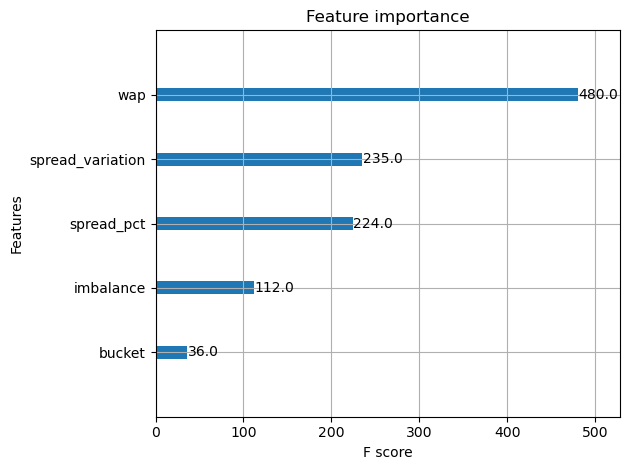

In [27]:


model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)



y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print("📊 Chronological 80/20 Split Evaluation:")
print(f"MSE: {mse:.6f}")
print(f"R²:  {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")



plot_importance(model)
plt.tight_layout()
plt.show()


In [28]:
model_better = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=100000000000)
model.fit(X_train, y_train)
# Define the parameter grid
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=model_better,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 28 candidates, totalling 84 fits
最佳参数: {'max_depth': 6, 'min_child_weight': 5}
最佳得分: -6.010385086111507e-07


In [29]:
# Use the current best max_depth and min_child_weight to validate
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=5,
    random_state=100000000000
)

# Define the range for gamma
param_grid = {
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5]
}

# Set up grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Output the best gamma and score
print("Best gamma:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
最佳 gamma: {'gamma': 0}
最佳得分: -6.010385086111507e-07


In [30]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=5,
    gamma=0,
    random_state=100000000000
)

# the range for subsample and colsample_bytree
param_grid = {
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 42 candidates, totalling 126 fits
最佳参数: {'colsample_bytree': 1.0, 'subsample': 1.0}
最佳得分: -6.325434895388041e-07


In [31]:

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=5,
    gamma=0,
    subsample=1.0,
    colsample_bytree=0.0,
    random_state=42
)

param_grid = {
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1],   # L1 regularization
    'reg_lambda': [0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.5]  # L2 regularization
}

# Set up grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print("Best regularization parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 35 candidates, totalling 105 fits
最佳正则化参数: {'reg_alpha': 0.1, 'reg_lambda': 1.2}
最佳得分: -6.043442954409832e-07


In [32]:
final_model = XGBRegressor(
    learning_rate=0.05,
    n_estimators=300,  # add more tree num to make up for learning rate
    max_depth=2,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1.5,
    random_state=100000000000
)

# final model
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print("✅ the final output：")
print(f"MSE: {mse:.8f}")
print(f"R² : {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")

✅ 最终模型评估结果：
MSE: 0.00000058
R² : 0.0250
QLIKE: -5.501175


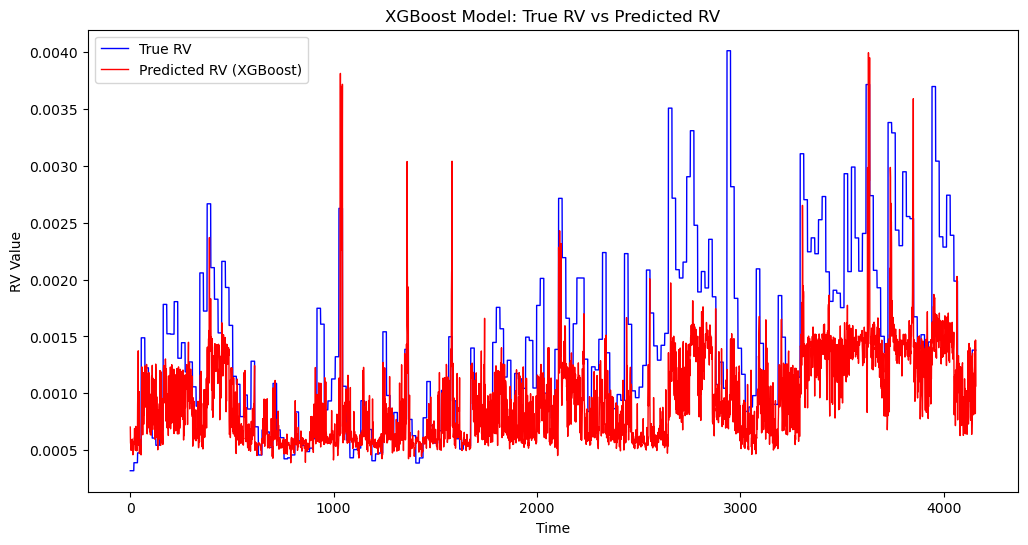

In [34]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True RV', color='blue', linewidth=1)
plt.plot(y_pred, label='Predicted RV (XGBoost)', color='red', linewidth=1)
plt.title('XGBoost Model: True RV vs Predicted RV')
plt.xlabel('Time')
plt.ylabel('RV Value')
plt.legend()
plt.show()
